In [1]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# import the functions from local directory
sys.path.append("../helpers/functions")
from spike_preprocessing import spike_band_filtering
from spike_detection import detect_spikes, get_waveforms

In [3]:
# define constants
SAMPLE_RATE = 25000
DT = 1 / SAMPLE_RATE
FILE_PATH = "/Volumes/WD Passport/DataScienceProject/220113_S1_m.h5"
PRIMARY_COLOUR = "black"
T = 100000

In [4]:
# the data is stored in hdf5 format
def print_structure(name, obj):
    print(name)

with h5py.File(FILE_PATH, "r") as f:

    # view the hdf5 file structure
    f.visititems(print_structure)

    # get the channel data
    channel_data = f['Data/Recording_0/AnalogStream/Stream_0/ChannelData']

    print(f"\nChannel Data is type: {type(channel_data)} of size: {channel_data.size} and shape: {channel_data.shape}")
    
    # access the first second of data points from each channel
    first_second_of_data = channel_data[:, :SAMPLE_RATE]

    two_thousandth_second_of_data = channel_data[:, 2000 * SAMPLE_RATE:2001* SAMPLE_RATE]
    five_thousandth_second_of_data = channel_data[:, 4500 * SAMPLE_RATE:4501* SAMPLE_RATE]
    
    print(f"\n{len(first_second_of_data)} channels with {len(first_second_of_data[0])} values in each")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Volumes/WD Passport/DataScienceProject/220113_S1_m.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Let's access the first second of data and show how some of the channels simultaneously

In [ ]:
filtered_data = spike_band_filtering(y=two_thousandth_second_of_data, sample_rate=SAMPLE_RATE, low=500, high=4000)

NameError: name 'two_thousandth_second_of_data' is not defined

Compare the first channels signal before and after filtering

In [ ]:
t = np.arange(0, T) * DT 
print(t)
print(len(t))

[0.00000e+00 4.00000e-05 8.00000e-05 ... 3.99988e+00 3.99992e+00
 3.99996e+00]
100000


In [ ]:
filtered_data[49][0:T]
len(filtered_data[49][0:T])

25000

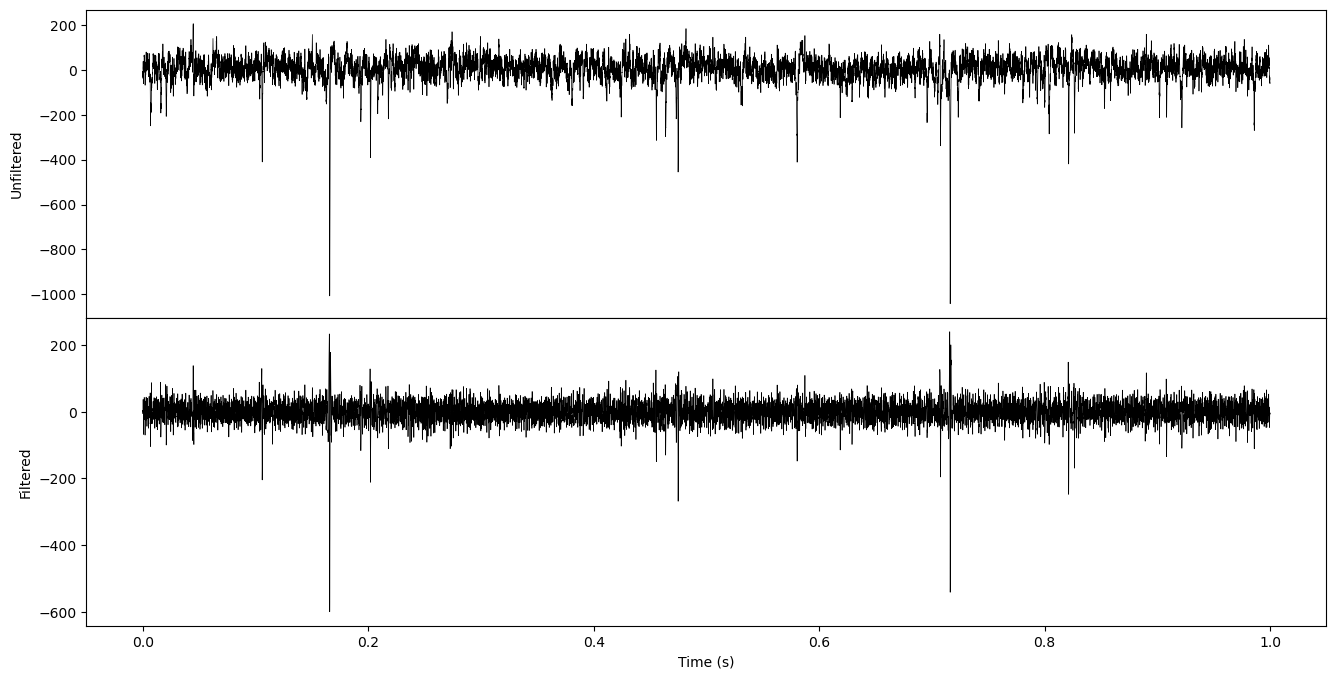

In [ ]:
channel = 49

# so the time difference between each data point is 1/25000 seconds
time = np.arange(len(filtered_data[channel])) / SAMPLE_RATE

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

axs[0].plot(time, two_thousandth_second_of_data[channel], c=PRIMARY_COLOUR, lw=0.5)
axs[0].set_ylabel(f'Unfiltered') 
axs[1].plot(time, filtered_data[channel], c=PRIMARY_COLOUR, lw=0.5)
axs[1].set_ylabel(f'Filtered') 

axs[-1].set_xlabel('Time (s)') 

plt.subplots_adjust(hspace=0) 
plt.show()

In [ ]:
# calculate the threshold for each channel
threshold_multiplier = -3.5

mad = np.median(np.abs(filtered_data - np.median(filtered_data, axis=1, keepdims=True)) / 0.6745, axis=1)
thresholds = threshold_multiplier * mad

Text(0, 0.5, 'Voltage')

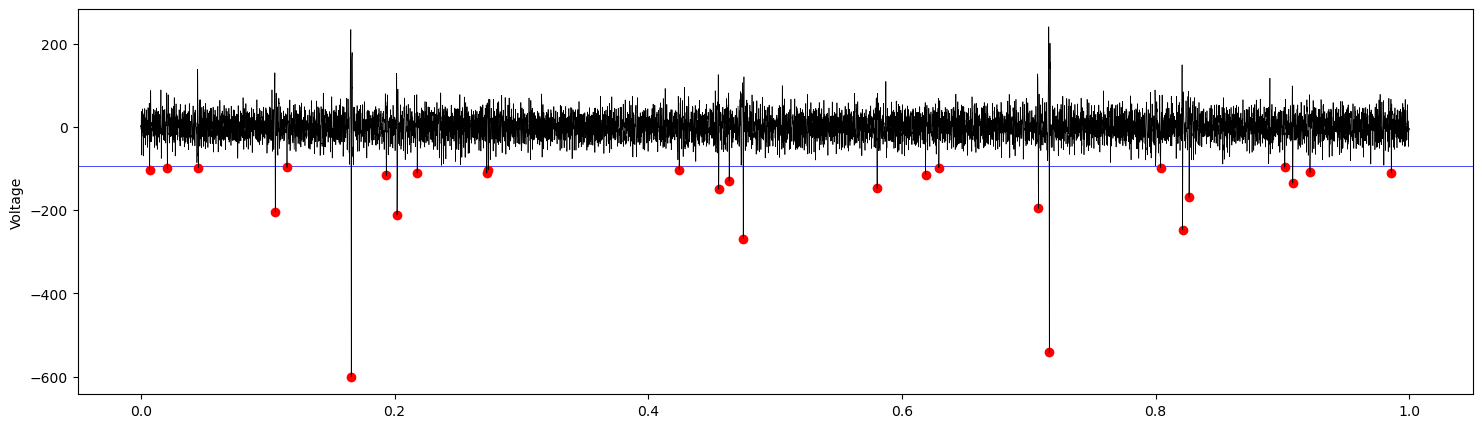

In [ ]:
# channel to visualise
channel = 49

# get this channel's threshold value
threshold = thresholds[channel]

spikes = detect_spikes(filtered_data[channel], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, flipped=True)

plt.figure(figsize=(18, 5))

plt.plot(time, filtered_data[channel], label='Raw Data', c=PRIMARY_COLOUR, lw=0.5)
plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
plt.scatter(spikes * DT, filtered_data[channel][spikes], color='red')

plt.ylabel('Voltage')

In [ ]:
waveforms, waveform_info = get_waveforms(y=filtered_data[channel], spike_indices=spikes, duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)

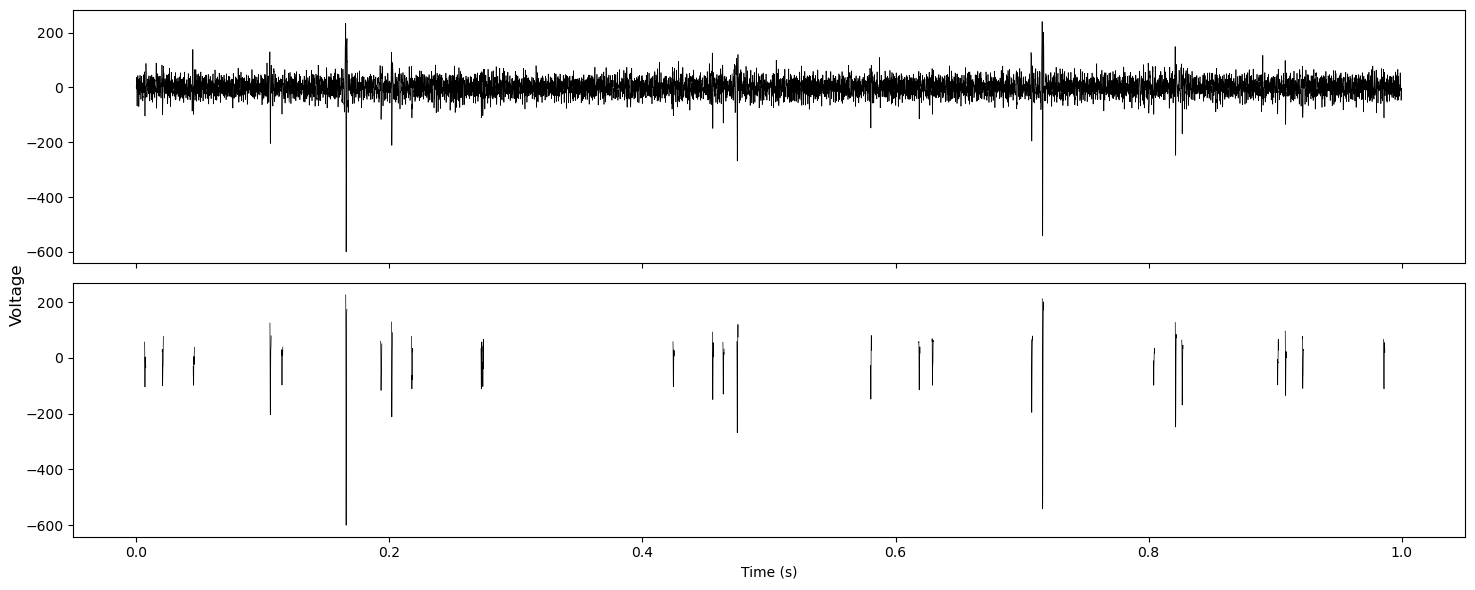

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
time = np.arange(len(filtered_data[channel])) / SAMPLE_RATE

# plot the filtered data
axs[0].plot(time,  filtered_data[channel], label='Raw Data', c=PRIMARY_COLOUR, lw=0.5)

# iterate through each spike and plot its waveform
for spike in waveform_info:
    spike_window = slice(spike["spike_start"], spike["spike_end"])
    axs[1].plot(time[spike_window], filtered_data[channel][spike_window], c=PRIMARY_COLOUR, lw=0.5)

axs[1].set_xlabel('Time (s)')
fig.supylabel("Voltage")

plt.tight_layout()
plt.show()

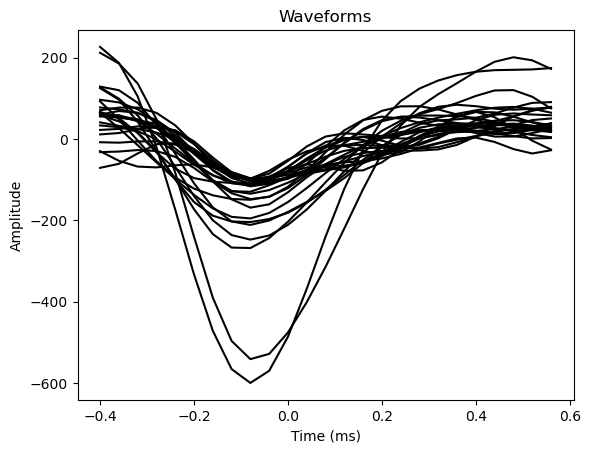

In [ ]:
# iterate over the waveforms and plot each on top of each other
for i, waveform in enumerate(waveforms):
    t = np.arange(-10, 15) * DT * 1000 

    # plot the waveform
    plt.plot(t, waveform, c="black")

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Waveforms')
plt.show()